In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=1200

import numpy as np
import yfinance as yf # pip install yfinance
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

import datetime as dt
#pip install arch
from arch import arch_model

In [2]:
start = dt.date(2019,1,1)
end = dt.date(2022,12,31)

ticker = ['^GSPC', 'AMZN']
name = 'S and P 500'

In [4]:
data = pd.DataFrame(yf.download(
    ticker,
    start=start,
    end=end,
    period='1d')['Close'])

data['r1'] = data[ticker[1]].pct_change()*100
data['rm'] = data[ticker[0]].pct_change()*100

data.dropna(axis=0, inplace=True)

model = MarkovRegression(
    endog=data['r1'], 
    exog=data['rm'],
    k_regimes=3,
    trend='c',
    switching_trend=True,
    switching_exog=True,
    switching_variance=True).fit()

print(model.summary())

[                       0%                       ]

[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                     r1   No. Observations:                 1007
Model:               MarkovRegression   Log Likelihood               -1730.502
Date:                Tue, 18 Feb 2025   AIC                           3491.005
Time:                        00:13:23   BIC                           3564.726
Sample:                             0   HQIC                          3519.014
                               - 1007                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0417      0.052     -0.809      0.419      -0.143       0.059
x1             0.7807      0.035     22.300      0.0

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


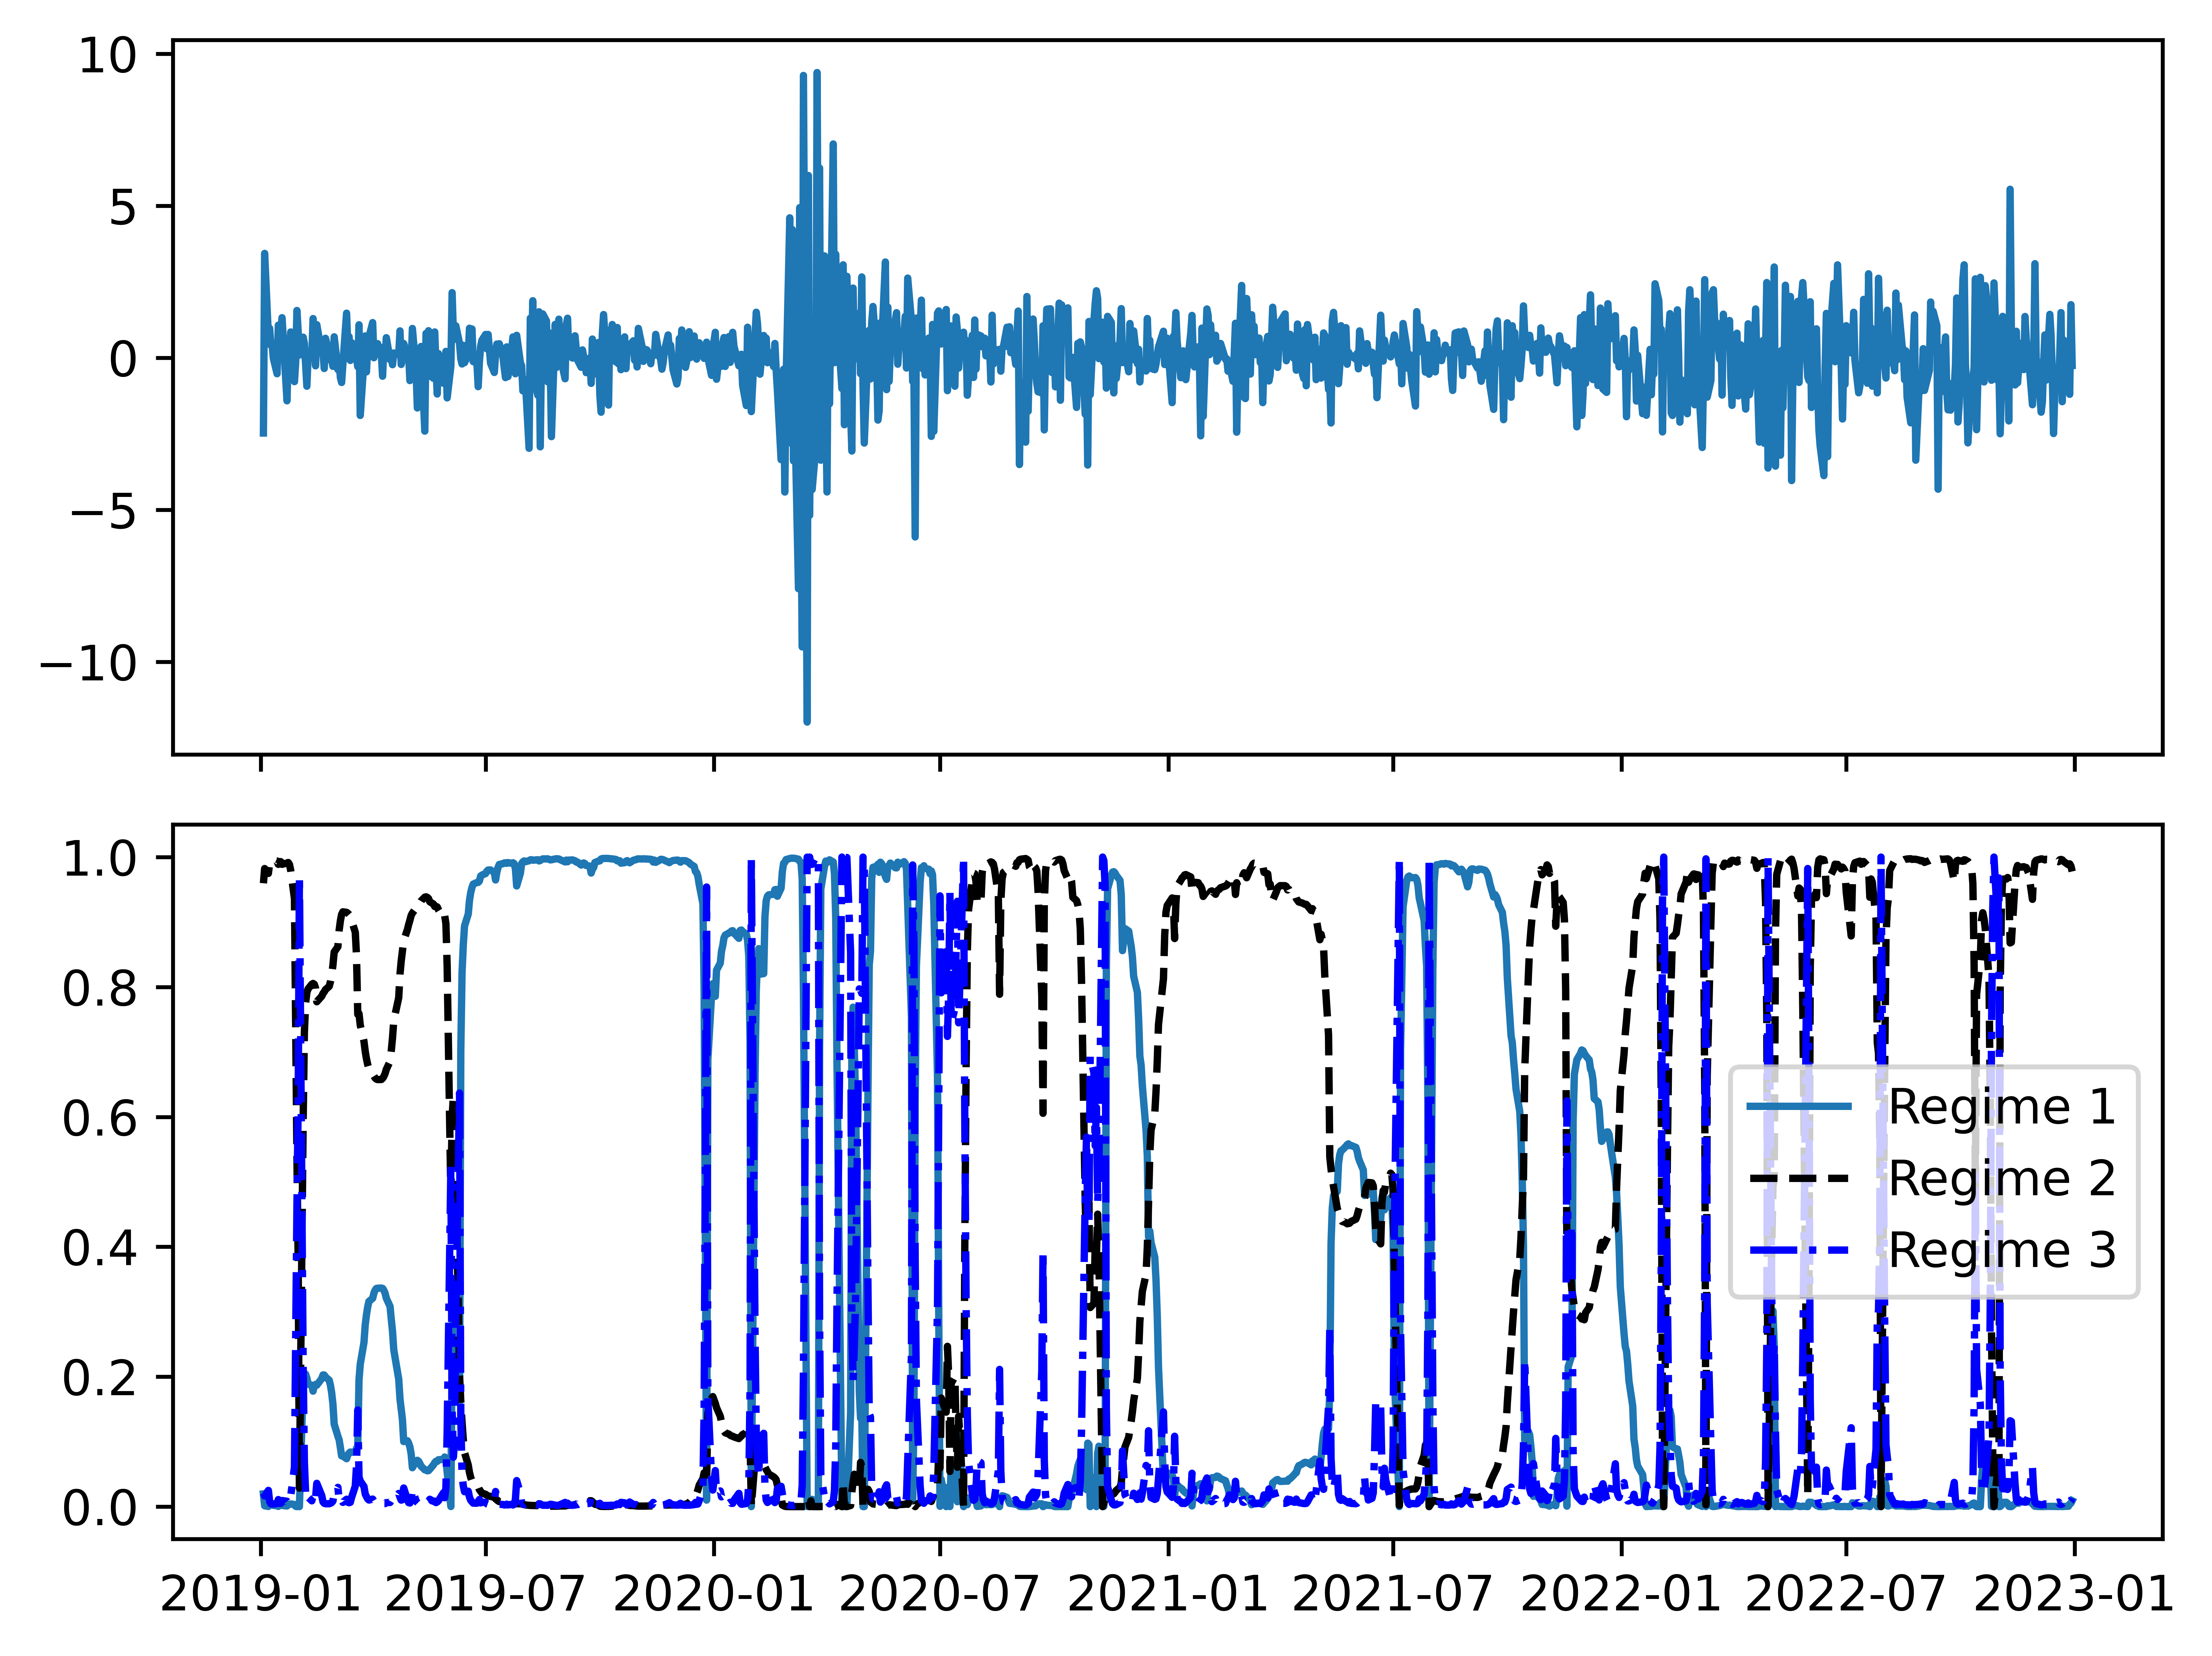

In [5]:
smoothed_prob = model.smoothed_marginal_probabilities

fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(data.index, data['rm'])

axes[1].plot(data.index, smoothed_prob[0], label='Regime 1')
axes[1].plot(data.index, smoothed_prob[1], label='Regime 2',
             linestyle = '--', c='k')
axes[1].plot(data.index, smoothed_prob[2], label='Regime 3',
             linestyle = '-.', c='b')
axes[1].legend()
plt.tight_layout()
plt.show()

# AR 1 model for amazon returns (simple)

In [6]:

data['lagged_amzn'] = data['r1'].shift(1)
data.dropna(axis=0, inplace=True)
model_ar1 = MarkovRegression(
    endog=data['r1'], 
    exog=data['lagged_amzn'],
    k_regimes=2,
    trend='c',
    switching_trend=True,
    switching_exog=True,
    switching_variance=True).fit()

print(model_ar1.summary())

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                     r1   No. Observations:                 1006
Model:               MarkovRegression   Log Likelihood               -2111.431
Date:                Tue, 18 Feb 2025   AIC                           4238.862
Time:                        00:14:15   BIC                           4278.172
Sample:                             0   HQIC                          4253.798
                               - 1006                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0925      0.058      1.604      0.109      -0.021       0.206
x1             0.0191      0.041      0.464      0.6

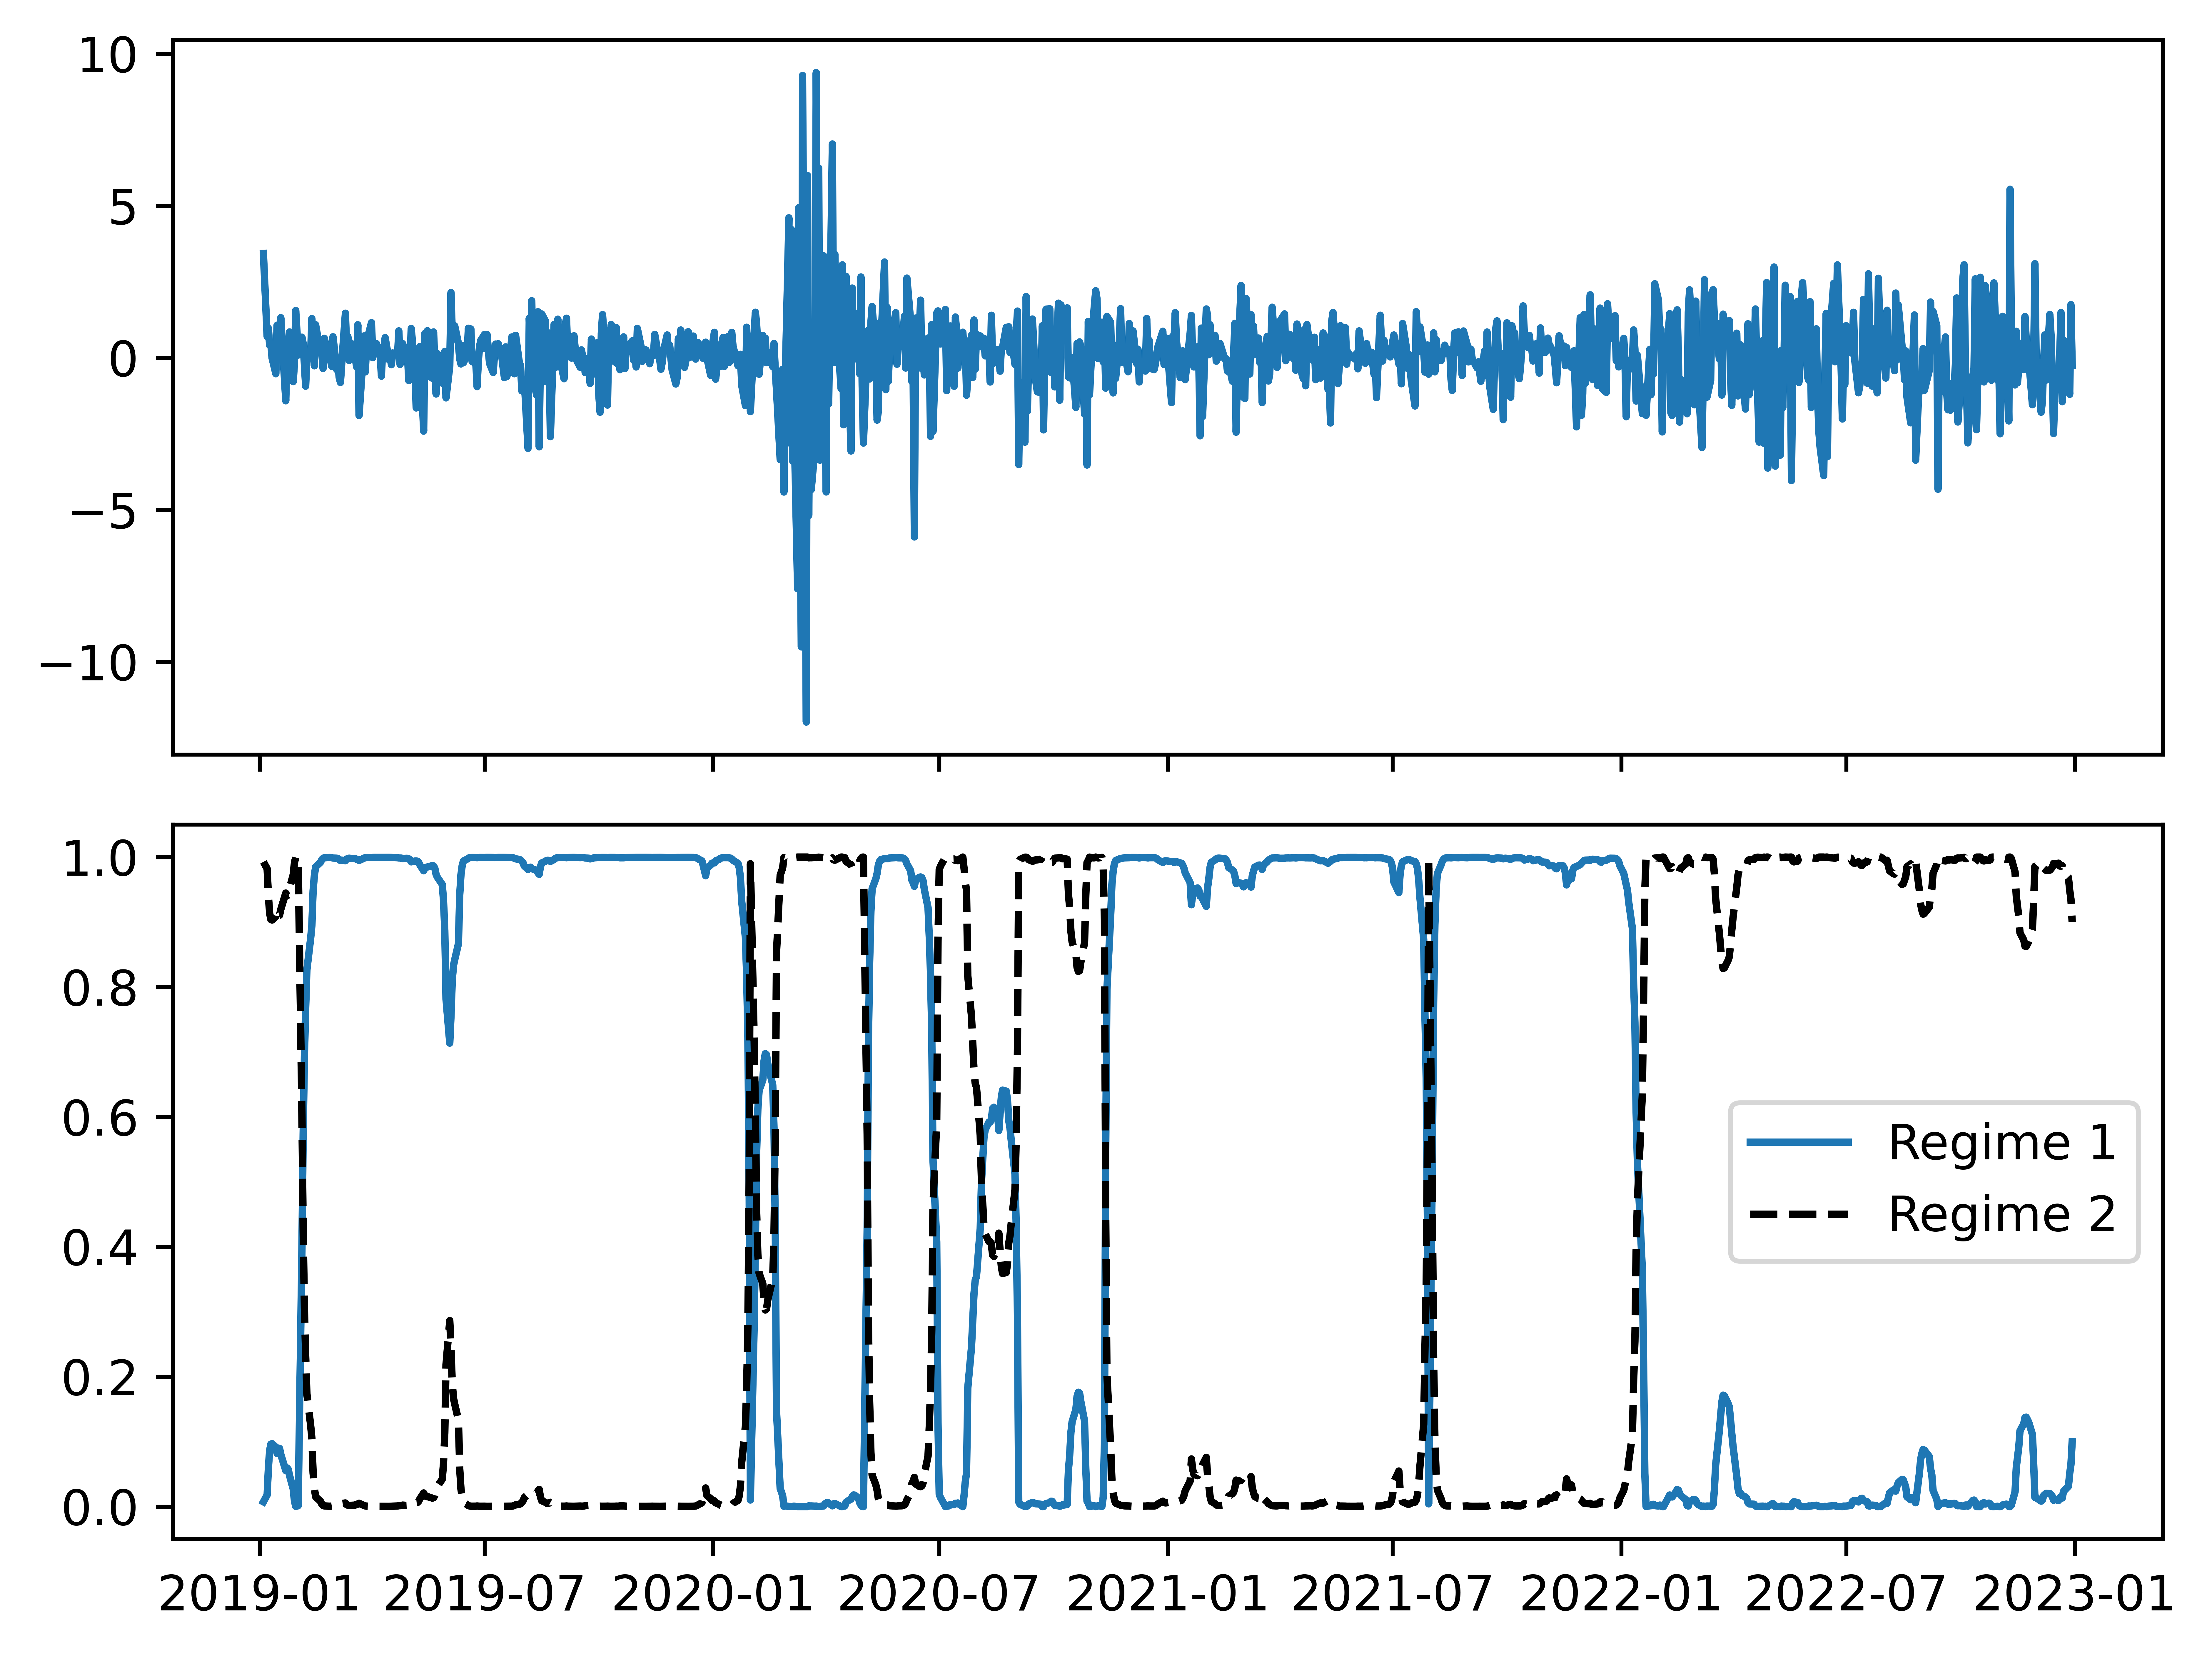

In [7]:
smoothed_prob_ar1 = model_ar1.smoothed_marginal_probabilities

fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(data.index, data['rm'])

axes[1].plot(data.index, smoothed_prob_ar1[0], label='Regime 1')
axes[1].plot(data.index, smoothed_prob_ar1[1], label='Regime 2',
             linestyle = '--', c='k')
axes[1].legend()
plt.tight_layout()
plt.show()

## Different method: using MarkovAutoregressions

In [9]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
model_ar1 = MarkovAutoregression(
    endog=data['r1'],
    k_regimes=2,           # 2 regimes
    order=1,               # AR(1)
    switching_ar=True,     # Allow AR coefficient to differ across regimes
    switching_variance=True).fit()

print(model_ar1.summary())





/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                         Markov Switching Model Results                         
Dep. Variable:                       r1   No. Observations:                 1005
Model:             MarkovAutoregression   Log Likelihood               -2107.464
Date:                  Tue, 18 Feb 2025   AIC                           4230.928
Time:                          00:17:10   BIC                           4270.230
Sample:                               0   HQIC                          4245.862
                                 - 1005                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0990      0.059      1.679      0.093      -0.017       0.215
sigma2         1.8292      0.119    